# Préparez des données pour un organisme de santé publique

<img src="img/oc.png" width="300" height="300"/>

In [1]:
from enum import Enum
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

import re
from wordcloud import WordCloud, STOPWORDS

import scipy.stats as st

from sklearn import decomposition
from sklearn import preprocessing
from functions import *

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
# afficher tout le dataset
def plot_data(df):
    '''
    Visualize the hole dataset in order to see the missing values
    Input:
        - df: DataFrame to plot
    '''
    plt.figure(figsize=(15, 10))
    sns.heatmap(df.isna(), cbar = False)
    plt.title('Entire dataset',fontsize=25)
    plt.xlabel('Variables',fontsize=15)
    plt.ylabel('Observations',fontsize=15)

In [3]:
class DensityTypes(Enum):
    Density = 1,
    Boxplot = 2

In [4]:
def plot_density(df, columns = np.NaN, dt = DensityTypes.Density):
    '''
    Used to plot density for a dataframe columns
    Input:
        df - the dataframe
        columns - a list of columns if it is nan than all the columns in the dataframe are selected
    '''
    if columns is np.NaN:
        columns = df.select_dtypes(include=np.number).columns
    
    fig, axes = plt.subplots(round(len(columns)/2+.1), 2, figsize=(30, 15), constrained_layout=True);
    
    on_col=0
    on_line=0
    for index, col in enumerate(columns):
        if (dt == DensityTypes.Density):
            sns.distplot(df[col], label=col, ax=axes[on_line, on_col%2], bins=100);
        elif (dt == DensityTypes.Boxplot):
            sns.boxplot(df[col], ax=axes[on_line, on_col%2]);
        #sns.histplot(df[col], kde=True, stat="density", linewidth=0, ax=axes[on_line, on_col%2])
        #axes[on_line, on_col%2].set_title('{0} distribution'.format(col,fontsize=25));
        axes[on_line, on_col%2].set_xlabel(col, fontsize=15);
        axes[on_line, on_col%2].set_ylabel('Density', fontsize=15);
        if on_col%2 == 1: on_line+=1
        on_col+=1;
    plt.show();


In [5]:
def plot_words(df, col):
    #take not nan values
    df = df[~df[col].isna()]
    
    # Remove punctuation
    
    df[col].map(lambda x: re.sub('[,\.!?]', '', x))

    # Convert the titles to lowercase
    
    df[col].map(lambda x: x.lower())

    # Print out the first rows of papers
    df[col].head()


    # Join the different processed titles together.
    long_string = ','.join(list(df[col].values))
    # Create a WordCloud object
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')# Generate a word cloud
    wordcloud.generate(long_string)# Visualize the word cloud
    plt.figure( figsize=(15,10) )
    plt.imshow(wordcloud)
    plt.show()

In [6]:
def compute_words_freq(df, var, sep=None):
    var_new = var + '_new'
    # compute function most common wolrd
    if sep is None:
        # make counting for each word
        df[var_new] = df[var].str.lower().str.replace('[^\w\s]','') 
        df_freq = df[var_new].str.split(expand=True).stack().value_counts().reset_index()
    else:
        # make counting for each sequances of worlds separated by sep for example ','
        df[var_new] = df[var].str.lower()
        df_freq = df[var_new].str.split(sep,expand=True).stack().value_counts().reset_index()
    df_freq.columns = ['Word', 'Frequency'] 
    
    df.drop([var_new], inplace=True, axis=1)
    return df_freq

In [7]:
def print_columns(df):
    '''
    prints all columns 
    '''
    i=0
    for col in df.columns:
        i+=1
        print('{0}:{1}'.format(i,col))

In [8]:
def plot_correlation(df):
    corr = df.corr()
    # Fill redundant values: diagonal and upper half with NaNs 
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    return (corr
     .style
     .background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1)
     .highlight_null(null_color='#f1f1f1')  # Color NaNs grey
    )

In [9]:
def get_values_of_interest(df, col):
    '''
    Used to eliminate outliers
    Input:
        - df: DataFrame
        - col: the column to analyse
    
    computes 
        min, max, med = Q2, 
        Q1-first quartile, Q3 - third quartile
        IQ = Q3 - Q1
    returns Q1-1/5*IQ<(o1, o2)<Q1+1/5*IQ
    '''
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQ = Q3 - Q1
    o1 = max(0,Q1-1.5*IQ)
    o2 = Q3+1.5*IQ
    return (o1,o2)

In [31]:
def get_pandas_catVar_numVar(df, catVar, numVar):
    modalities = list(df[catVar].value_counts().index)

    groupes= {}
    for m in modalities:
        if m not in groupes:
            groupes[m] = 0;
        groupes[m] = list(df[df[catVar] == m][numVar]);



    labels, data = [*zip(*groupes.items())];  # 'transpose' items to parallel key, value lists

    # or backwards compatable    
    labels, data = groupes.keys(), groupes.values();

    data = pd.DataFrame(data);
    data = data.T;
    data.columns = labels;
    
    return data

In [11]:
def compute_energy(proteins, carbohydrates, fat):
    # 1g of fat is 39 kJ and 1g of carbohydrates or proteins is 17 kJ of energy .
    return 17*proteins + 17*carbohydrates + 39*fat 

def compute_nutrition_score_fr():
    return 0

def compute_nutrition_grade_fr():
    return 'a'

In [12]:
def eta_squared(df, var1, var2):
    """
    compute the correlation of a categorical variable and numerical variable
    Input:
        - df: the dataframe
        - x: categorical variable
        - y: numerical variable
    """
    X = df[var1]
    Y = df[var2]
    moyenne_y = Y.mean()
    classes = []
    for classe in X.unique():
        yi_classe = Y[X==classe]
        classes.append({'ni': len(yi_classe),
                        'moyenne_classe': yi_classe.mean()})
    
    SCT = sum([(yj-moyenne_y)**2 for yj in Y])
    SCE = sum([c['ni']*(c['moyenne_classe']-moyenne_y)**2 for c in classes])
    return SCE/SCT

**The data information and description** can be found on the OpenFoodData website: [OpenFood](https://world.openfoodfacts.org/)
    


## Importation des données

In [34]:
df = pd.read_csv('data/df_voila.csv')

## VAR quantitative vs qualitative (ANOVA)

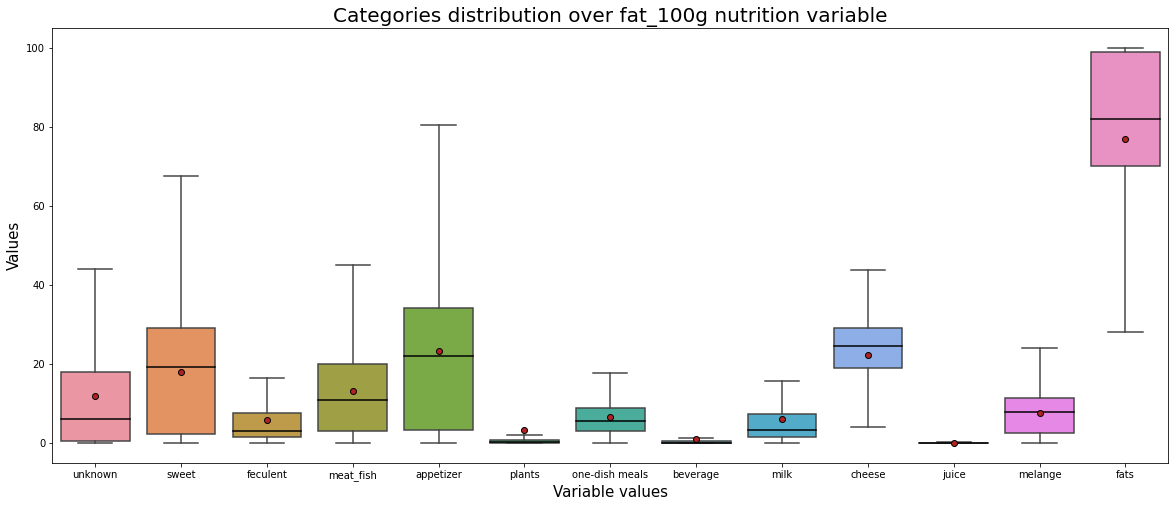

In [36]:
NVname = 'fat_100g'
data = get_pandas_catVar_numVar(df, catVar = 'my_categoty', numVar = NVname)

# Propriétés graphiques (pas très importantes)    
medianprops = {'color':"black"}
meanprops = {'marker':'o', 'markeredgecolor':'black',
            'markerfacecolor':'firebrick'}

plt.figure(figsize=(20,8));
b = sns.boxplot(x="variable", y="value", data=pd.melt(data), showfliers = False,  showmeans=True, medianprops=medianprops, meanprops=meanprops);
plt.title('Categories distribution over {0} nutrition variable'.format(NVname), fontsize=20);
plt.xlabel('Variable values', fontsize=15);
plt.ylabel('Values', fontsize=15);
plt.show();

## Entre 2 variables qualitatives

***Avez vous les même produits dans differents états?***

In [38]:
X = "my_categoty"
Y = "countries_fr_top5"

cont = df[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total")

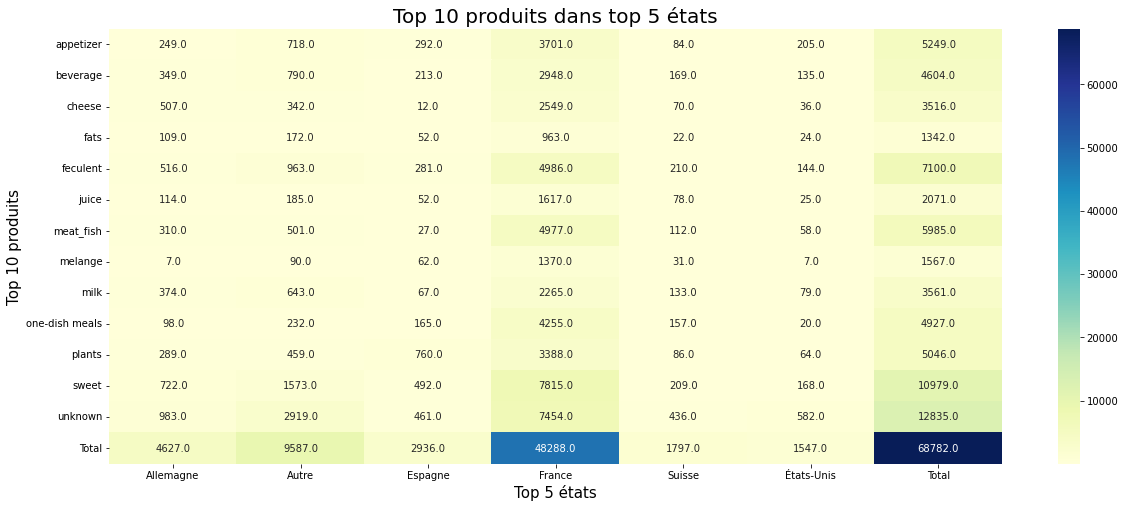

In [39]:
plt.figure(figsize=(20,8));
sns.heatmap(cont, cmap="YlGnBu", annot=True, fmt='.1f')
plt.title('C', fontsize=20);
plt.xlabel('Top 5 états', fontsize=15);
plt.ylabel('Top 10 produits', fontsize=15);

# Analyse des données

## Analyse univarié
### Densité des variables nutritionelle

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or mis

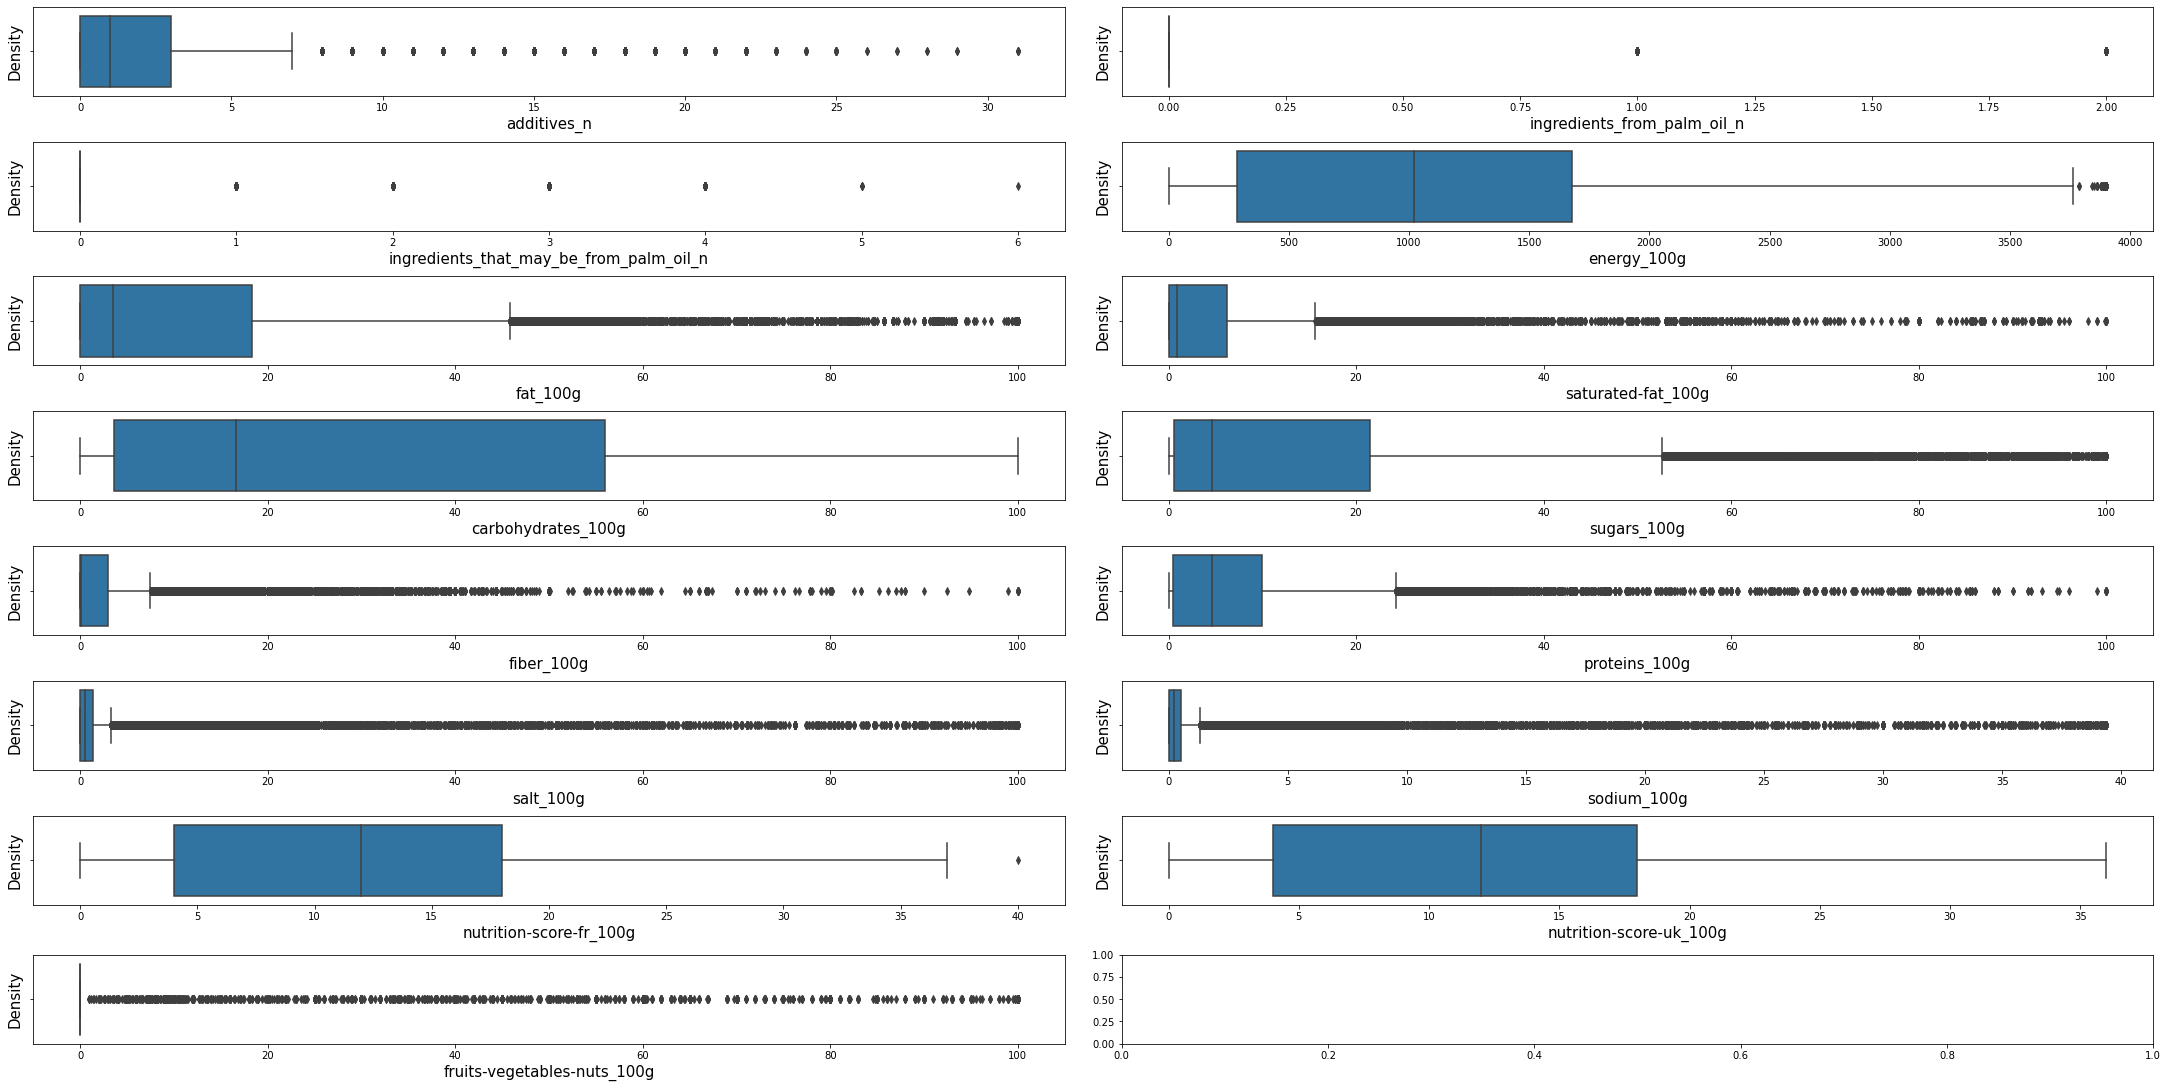

In [302]:
#plot_density(df_selected, dt = DensityTypes.Density)
plot_density(df_selected, dt = DensityTypes.Boxplot)

### Top 5 creators

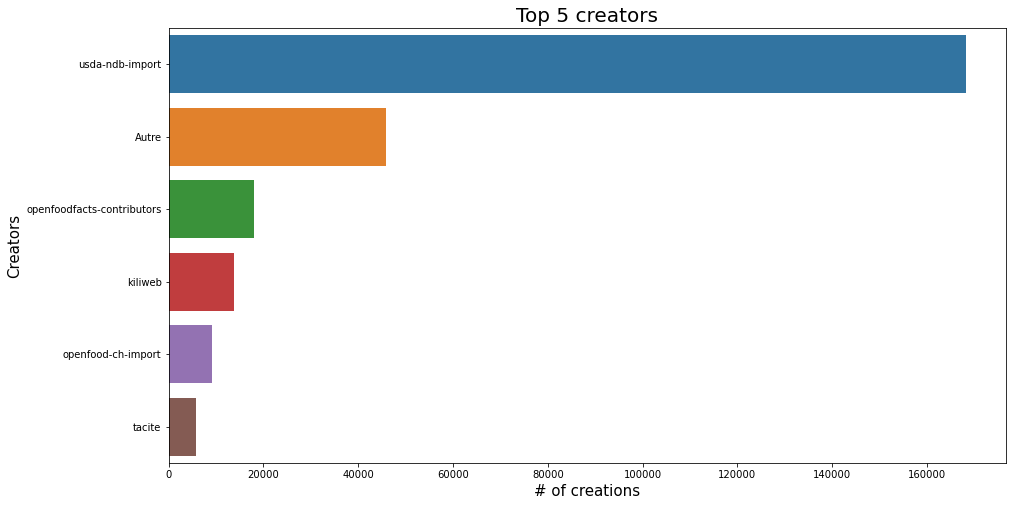

In [303]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.creator_top5.value_counts(), y=df_selected.creator_top5.value_counts().index, data=df_selected);
plt.title('Top 5 creators', fontsize=20);
plt.xlabel('# of creations', fontsize=15);
plt.ylabel('Creators', fontsize=15);
plt.show();

### Top 10 produits

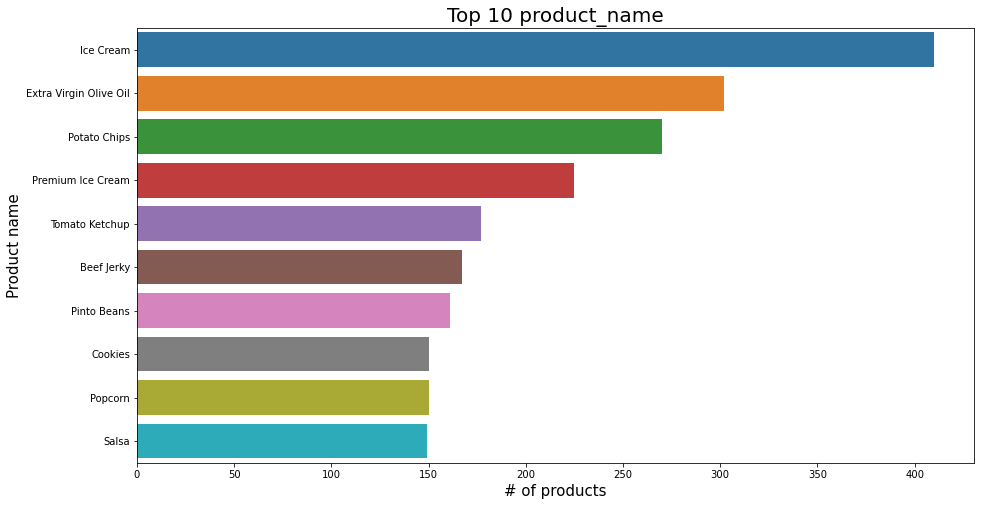

In [595]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.product_name.value_counts().head(10), y=df_selected.product_name.value_counts().head(10).index, data=df_selected);
plt.title('Top 10 product_name', fontsize=20);
plt.xlabel('# of products', fontsize=15);
plt.ylabel('Product name', fontsize=15);
plt.show();

### Top 10 brands

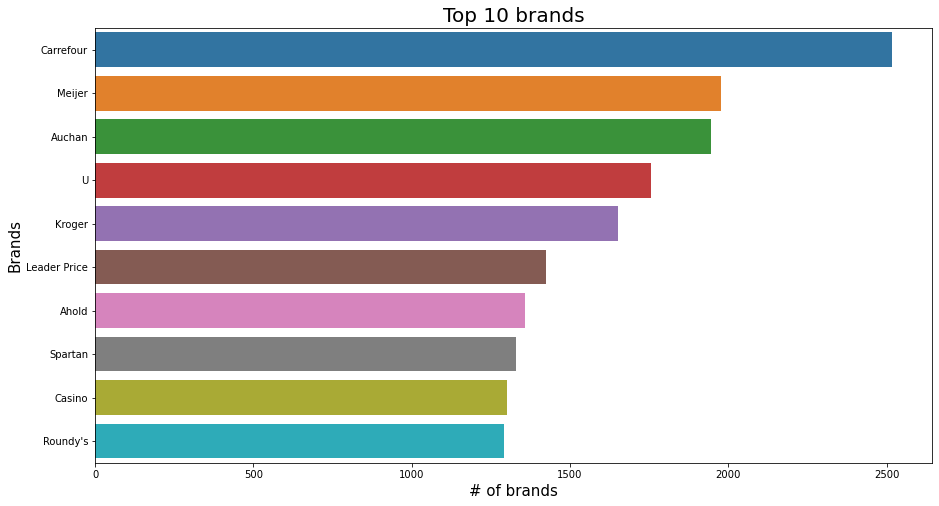

In [596]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.brands.value_counts().head(10), y=df_selected.brands.value_counts().head(10).index, data=df_selected);
plt.title('Top 10 brands', fontsize=20);
plt.xlabel('# of brands', fontsize=15);
plt.ylabel('Brands', fontsize=15);
plt.show();

### Top 10 ingredients

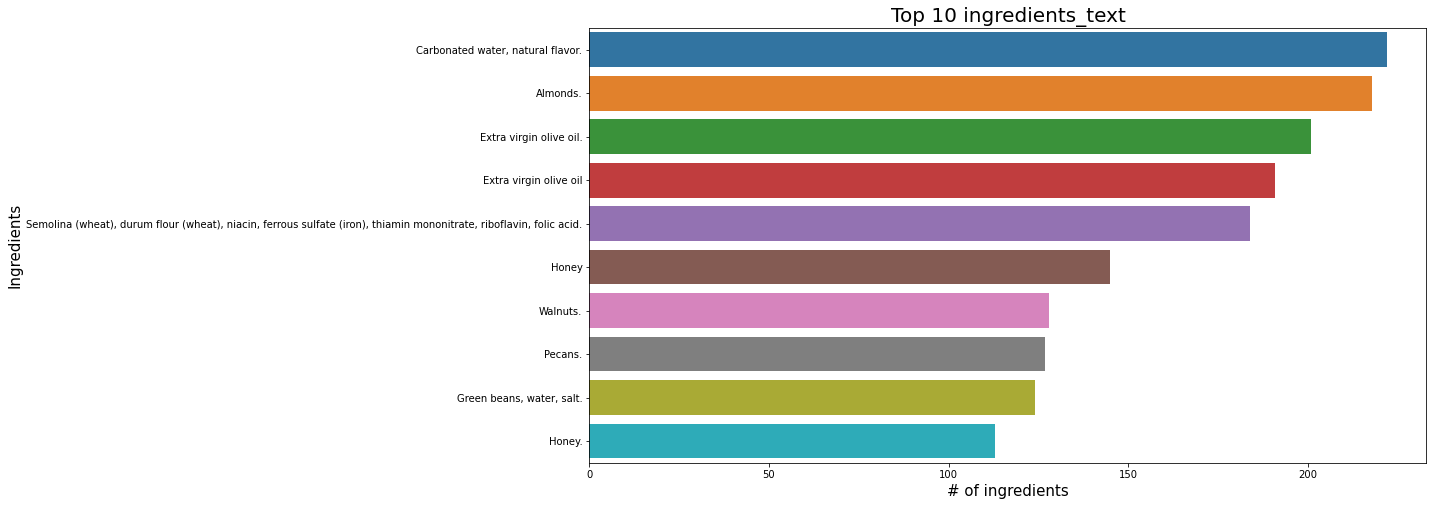

In [597]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.ingredients_text.value_counts().head(10), y=df_selected.ingredients_text.value_counts().head(10).index, data=df_selected);
plt.title('Top 10 ingredients_text', fontsize=20);
plt.xlabel('# of ingredients', fontsize=15);
plt.ylabel('Ingredients', fontsize=15);
plt.show();

### Top 10 additives

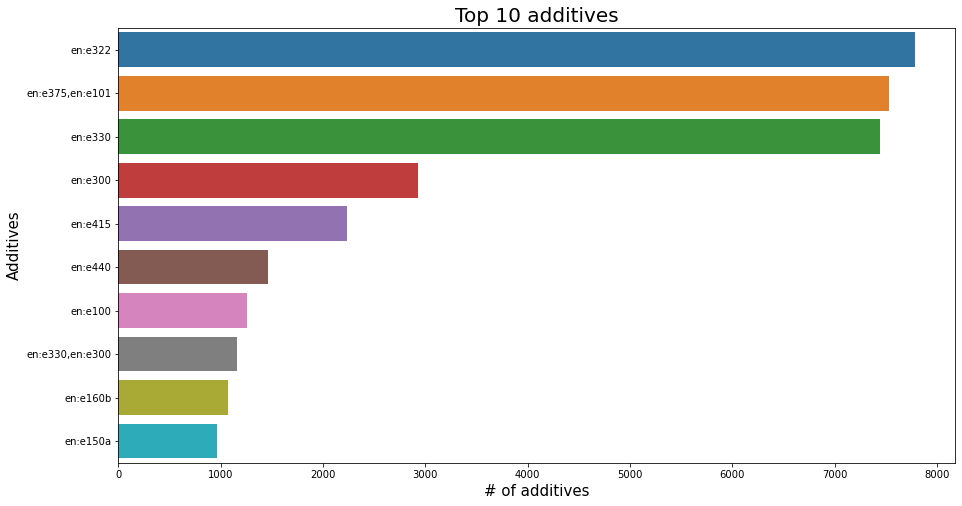

In [598]:
plt.figure(figsize=(15,8))
sns.barplot(x=df_selected.additives_tags.value_counts().head(10), y=df_selected.additives_tags.value_counts().head(10).index, data=df_selected);
plt.title('Top 10 additives', fontsize=20);
plt.xlabel('# of additives', fontsize=15);
plt.ylabel('Additives', fontsize=15);
plt.show();

### Top 10 pays

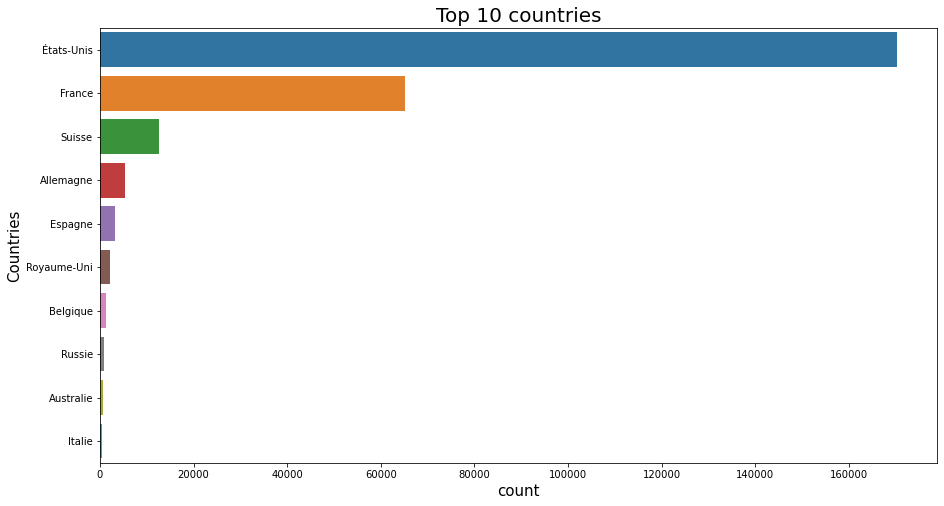

In [599]:
df1 =  df_selected.countries_fr.str.split(',', expand=True).melt(var_name='columns', value_name='values');
df2 = pd.crosstab(index=df1['values'], columns=df1['columns'], margins=True).All.drop('All').sort_values(ascending = False).head(10);
df2 = df2.to_frame();
#Using reset_index, inplace=True
df2.reset_index(inplace=True);

plt.figure(figsize=(15,8));
sns.barplot(y='values', x='All', data=df2);
plt.title('Top 10 countries', fontsize=20);
plt.xlabel('count', fontsize=15);
plt.ylabel('Countries', fontsize=15);
plt.show();

del df1, df2;

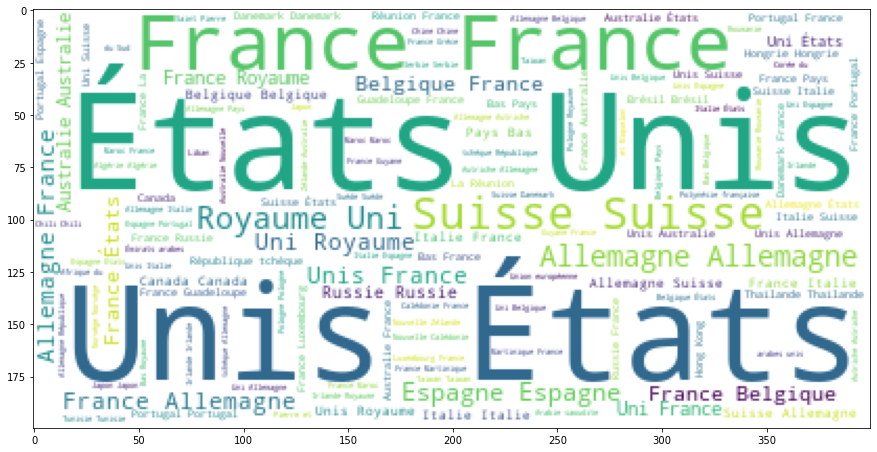

In [482]:
plot_words(df, 'countries_fr')

### Repartition de `nutriscore_grade`

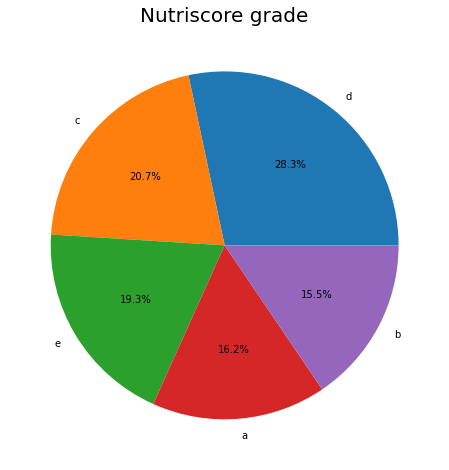

In [310]:
plt.figure(figsize=(15,8))
df_selected.nutrition_grade_fr.value_counts().plot.pie(autopct="%.1f%%");
plt.title('Nutriscore grade', fontsize=20);
plt.ylabel('');

## Analyse bivarié

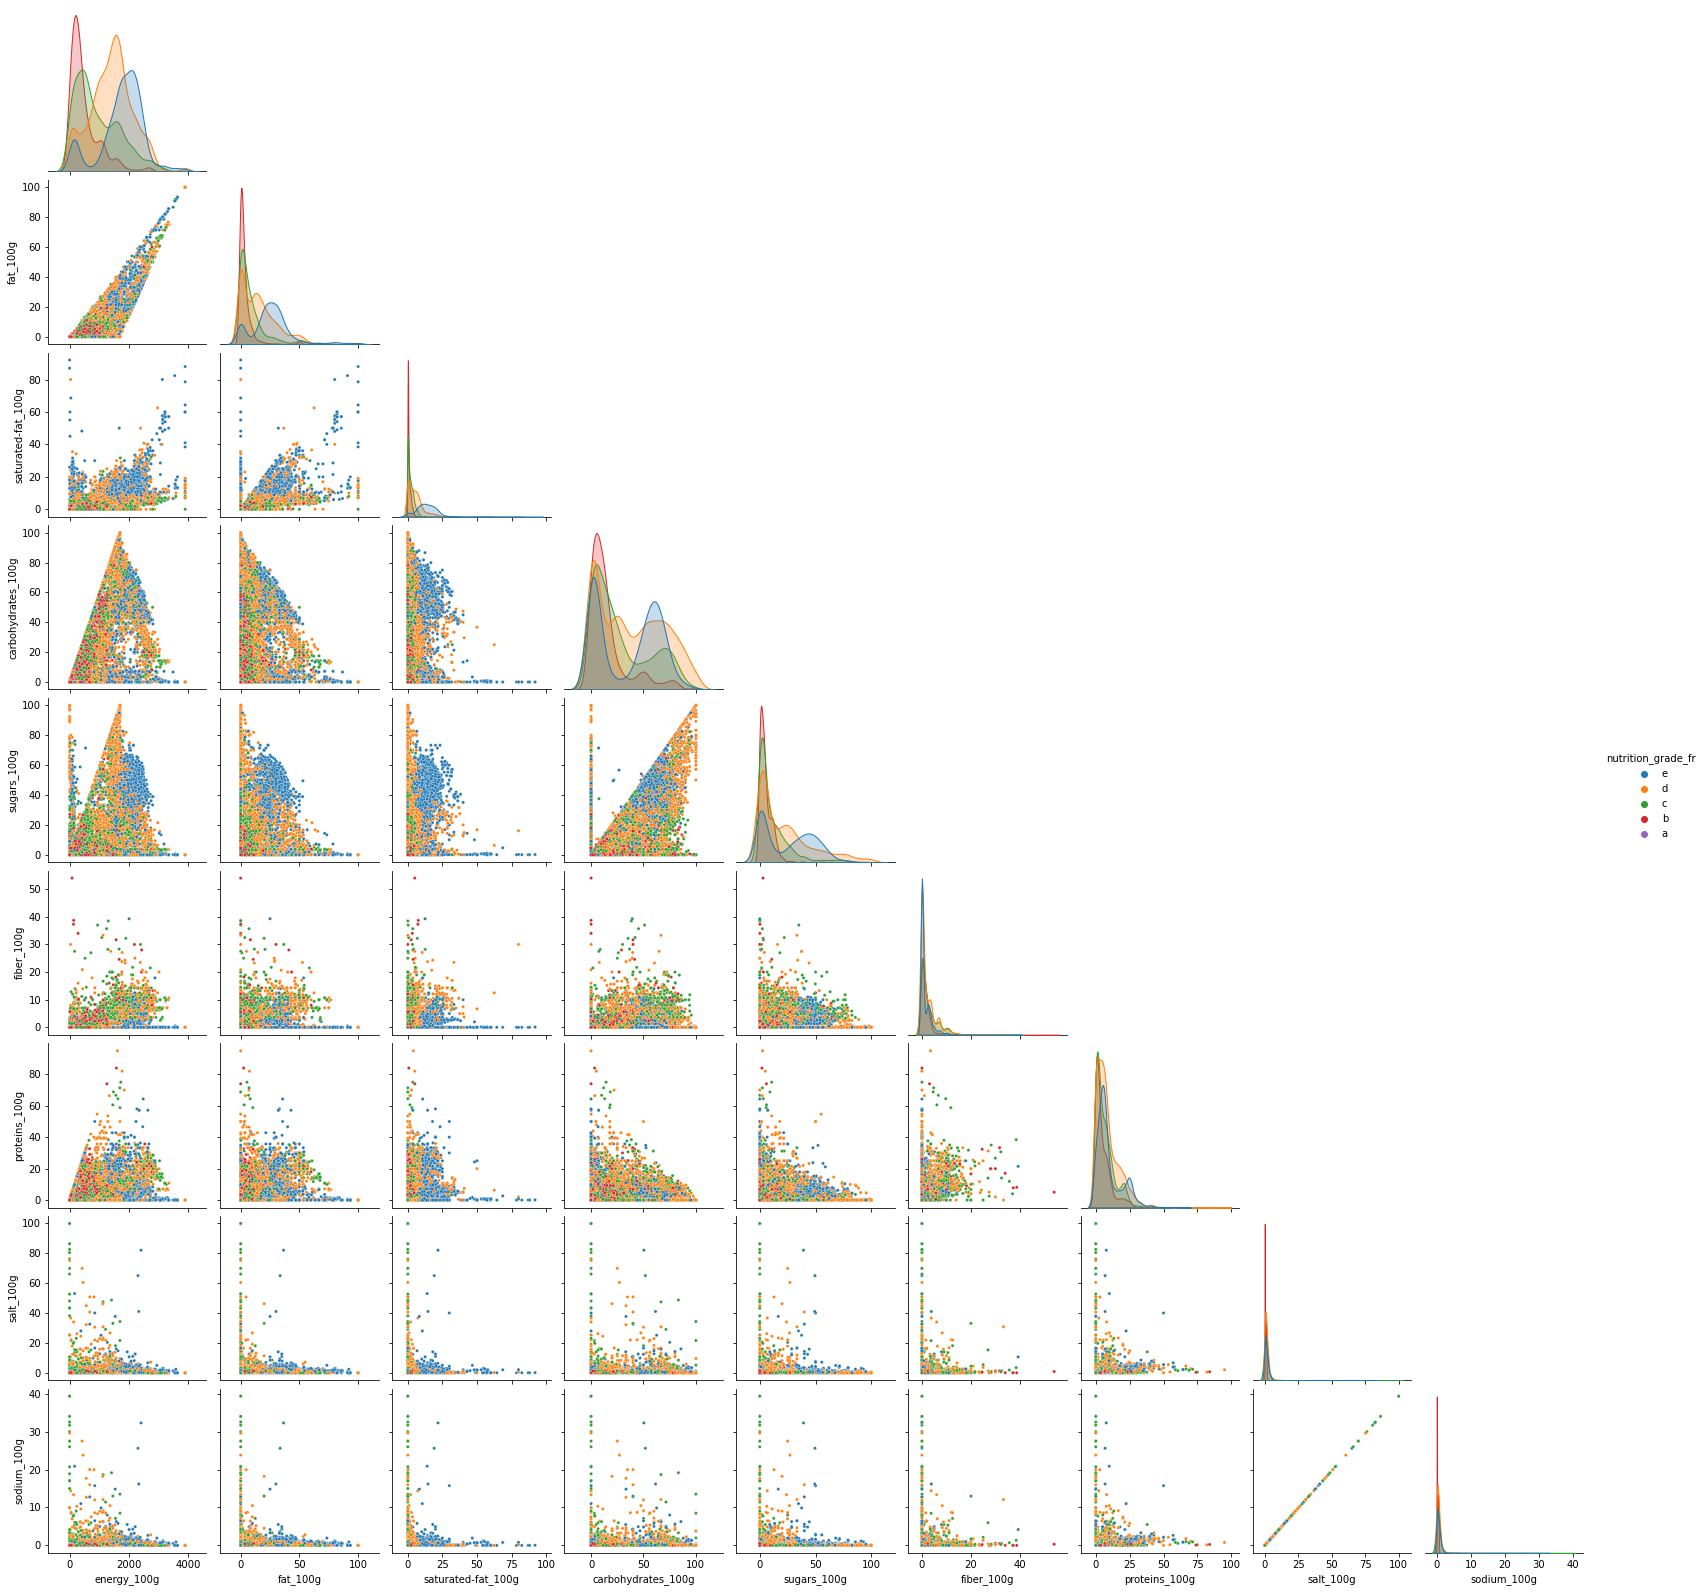

In [536]:
cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 
 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'nutrition_grade_fr']
d = df_selected[(~df_selected['nutrition_grade_fr'].isna()) & (~df_selected['nutrition-score-fr_100g'].isna())][cols].sample(10000)

sns.pairplot(data=d, hue="nutrition_grade_fr", hue_order=['e','d','c','b','a'], 
             plot_kws = {'s': 10}, corner=True)
del d

Observe the level of fats and that of saturated fats penalizes the nutriscore.  
Other nutrition compositions affects less the nutriscore.

Some of foods are rich in caloric energy having a good nutrition grade:
 - A high nutrition grade of 'a' and 'b' with energy in the range of 1500 can be observed with fat smaller then 20
 - A high nutrition grade of 'a' and 'b' with energy in range of 3000 can be observed with very less saturated fat that is less then 10. 
 - We observe foods with rich in carbohidrates that have a good nutrition score having more then 2000 in energy.
 
Theese can be also seen in the folowing 3 figures.

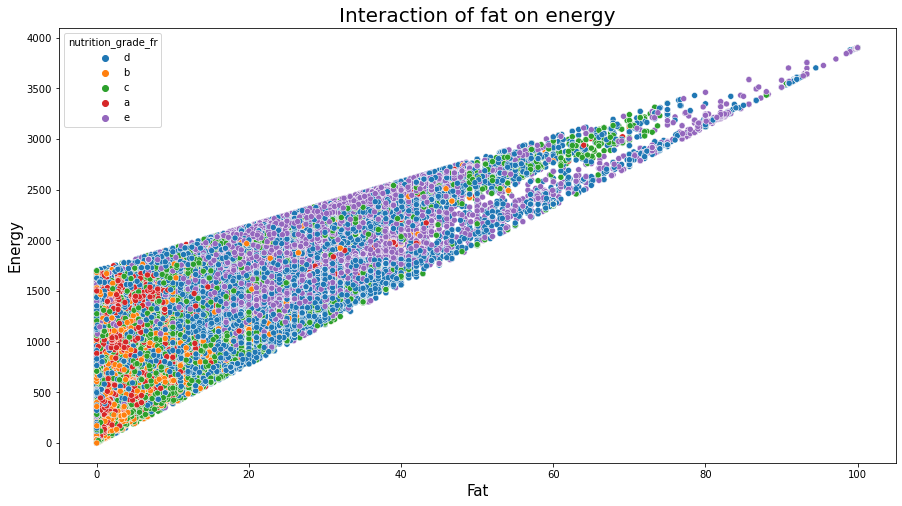

In [537]:
plt.figure(figsize=(15,8));
sns.scatterplot(data=df_selected, x="fat_100g", y="energy_100g", hue="nutrition_grade_fr")
plt.title('Interaction of fat on energy', fontsize=20);
plt.xlabel('Fat', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

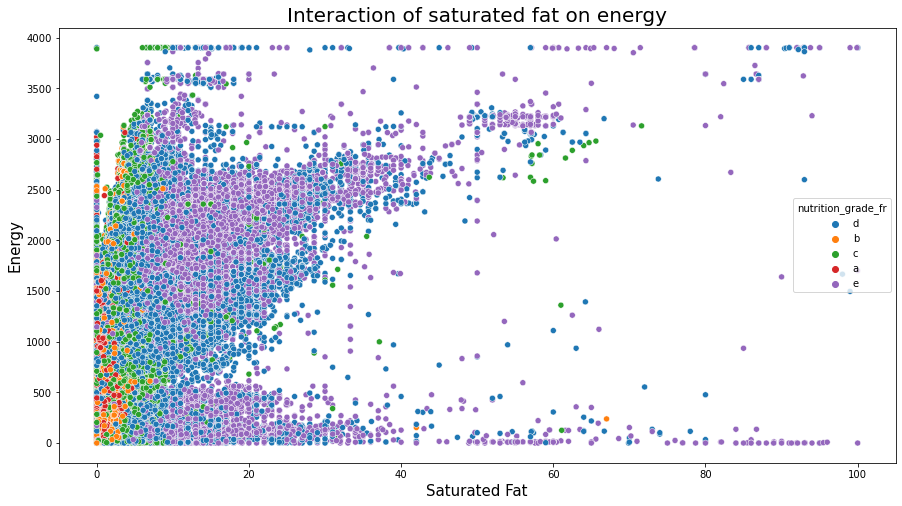

In [539]:
plt.figure(figsize=(15,8));
sns.scatterplot(data=df_selected, x="saturated-fat_100g", y="energy_100g", hue="nutrition_grade_fr")
plt.title('Interaction of saturated fat on energy', fontsize=20);
plt.xlabel('Saturated Fat', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

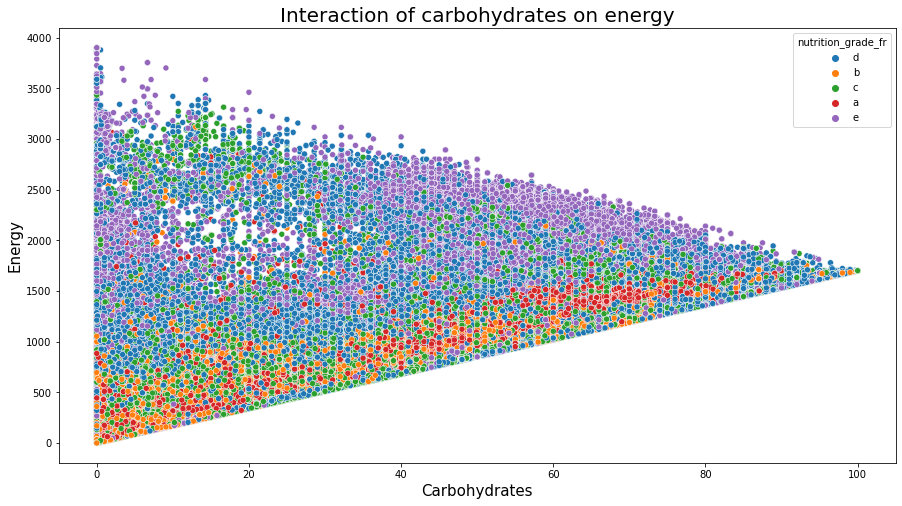

In [540]:
plt.figure(figsize=(15,8));
sns.scatterplot(data=df_selected, x="carbohydrates_100g", y="energy_100g", hue="nutrition_grade_fr")
plt.title('Interaction of carbohydrates on energy', fontsize=20);
plt.xlabel('Carbohydrates', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

### Nutrition grade distributions over the `energy_100g` nutrition variable.

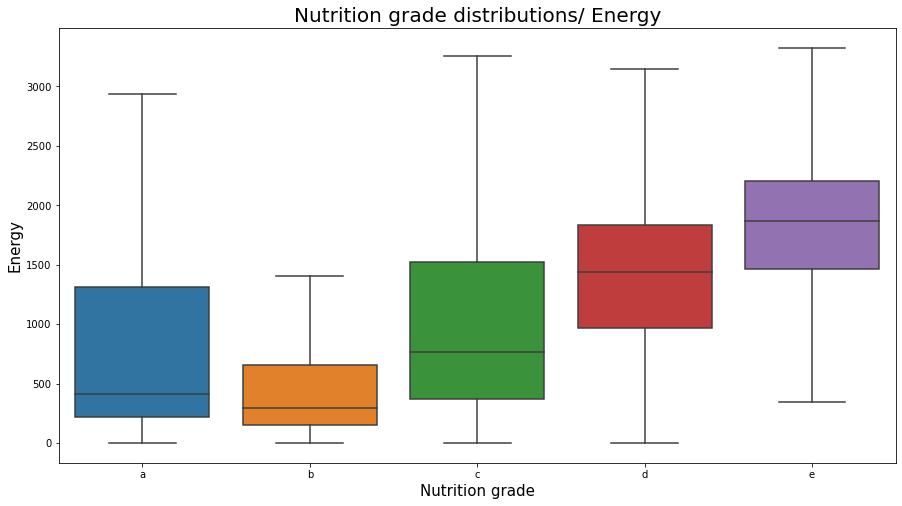

In [549]:
plt.figure(figsize=(15,8));
sns.boxplot(x="nutrition_grade_fr", y="energy_100g", data=df_selected, showfliers = False, order = ['a', 'b', 'c', 'd', 'e'])
plt.title('Nutrition grade distributions/ Energy', fontsize=20);
plt.xlabel('Nutrition grade', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

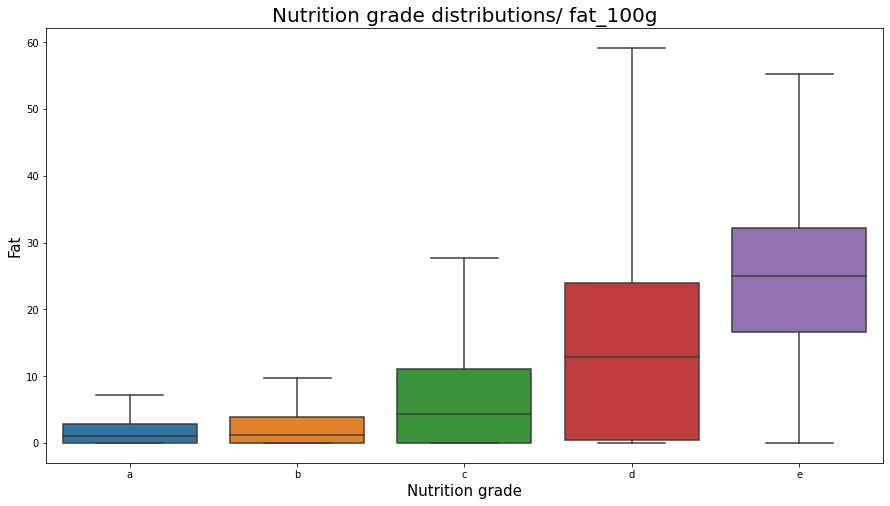

In [548]:
plt.figure(figsize=(15,8));
sns.boxplot(x="nutrition_grade_fr", y="fat_100g", data=df_selected, showfliers = False, order = ['a', 'b', 'c', 'd', 'e'])
plt.title('Nutrition grade distributions/ fat_100g', fontsize=20);
plt.xlabel('Nutrition grade', fontsize=15);
plt.ylabel('Fat', fontsize=15);
plt.show();

Note that all all foods with different nutrition grade can have relatively equal high energies. But prefering good foods we are likely to eat foods with less energies. The same thing we observe on fat foods, where preferring better foods (whith a better nutrition score) we shall choose not fat foods.

### Adding a variable containing the categories of foods

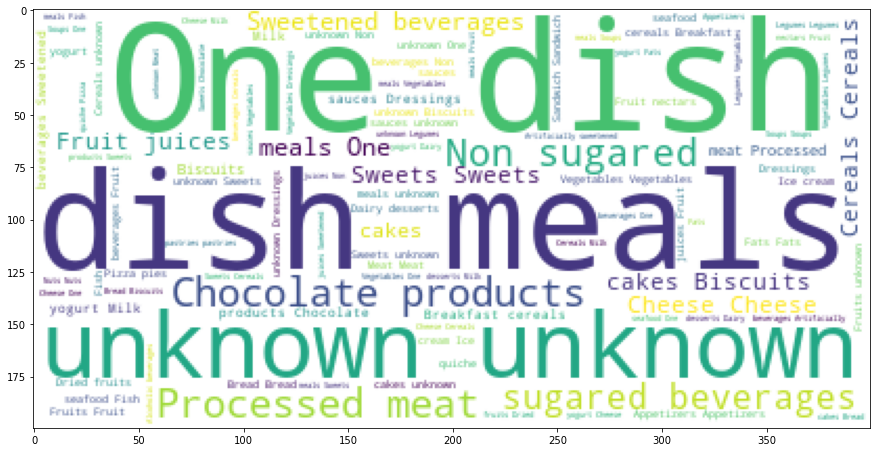

In [483]:
plot_words(df_selected, 'pnns_groups_2')

In [318]:
compute_words_freq(df_selected, 'pnns_groups_2', sep=',')

Word  Frequency
0                            unknown      12835
1                     one-dish meals       4927
2                 biscuits and cakes       4018
3                            cereals       3701
4                             sweets       3587
5                             cheese       3516
6                    milk and yogurt       2914
7               dressings and sauces       2785
8                 chocolate products       2648
9                         vegetables       2585
10                    processed meat       2548
11             non-sugared beverages       2242
12                  fish and seafood       2052
13               sweetened beverages       1952
14                        appetizers       1880
15                      fruit juices       1729
16                             bread       1590
17                              fats       1342
18                 breakfast cereals       1310
19                            fruits       1297
20                              meat       1150
21                           legumes        754
22                    dairy desserts        726
23                         ice cream        647
24                          sandwich        640
25                              nuts        565
26             pizza pies and quiche        464
27                             soups        463
28                      dried fruits        410
29                          pastries        403
30                     fruit nectars        342
31  artificially sweetened beverages        255
32                              eggs        186
33               alcoholic beverages        155
34                          potatoes         96
35                      tripe dishes         49
36          salty and fatty products         19

In [475]:
categories ={
    'cheese' : ['cheese'],
    'appetizer' : ['appetizers', 'nuts', 'salty and fatty products', 'dressings and sauces'],
    'melange': ['soups', 'sandwich', 'pizza pies and quiche'],
    'juice' : ['fruit juices', 'fruit nectars'],
    'plants' : ['legumes', 'legume', 'fruits', 'Fruit', 'vegetables', 'dried fruits'],
    'sweet' : ['sweets', 'biscuits and cakes', 'chocolate products', 'dairy desserts'],
    'feculent' : ['cereals', 'bread', 'pastries', 'potatoes', 'breakfast cereals' ],
    'beverage' : ['non-sugared beverages', 'artificially sweetened beverages', 'alcoholic beverages', 'sweetened beverages'],
    'meat_fish' : ['tripe dishes', 'meat','fish and seafood', 'processed meat', 'eggs'],
    'fats' : ['fats'],
    'milk' : ['milk and yogurt', 'ice cream'],
}
#categories = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in categories.items() ])).melt()
#categories = categories[~categories.value.isna()]

In [476]:
df_selected['my_categoty'] = df_selected['pnns_groups_2'].str.lower();
for new_value, old_value in categories.items():
    df_selected['my_categoty'] = df_selected['my_categoty'].replace([old_value], new_value);

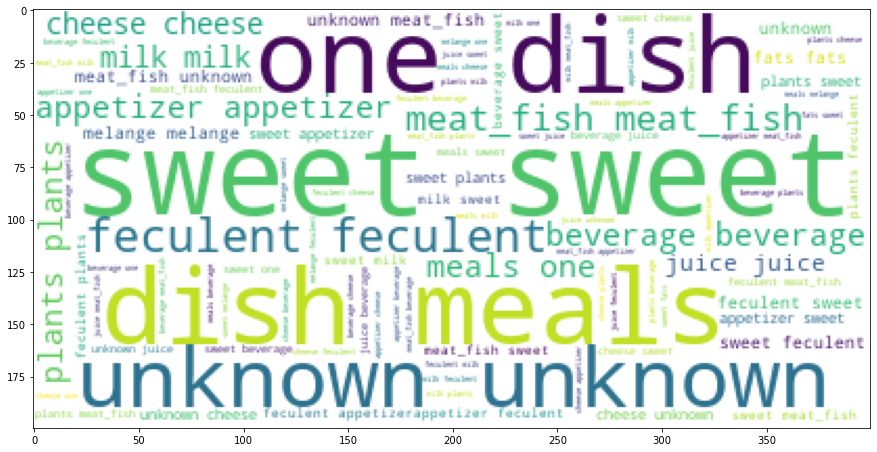

In [484]:
plot_words(df_selected, 'my_categoty')

In [485]:
compute_words_freq(df_selected, 'my_categoty')

Word  Frequency
0     unknown      12835
1       sweet      10979
2    feculent       7100
3   meat_fish       5985
4   appetizer       5249
5      plants       5046
6       meals       4927
7     onedish       4927
8    beverage       4604
9        milk       3561
10     cheese       3516
11      juice       2071
12    melange       1567
13       fats       1342

### Nutrition grade distributions over energy categorized by plants and meat_fish foods

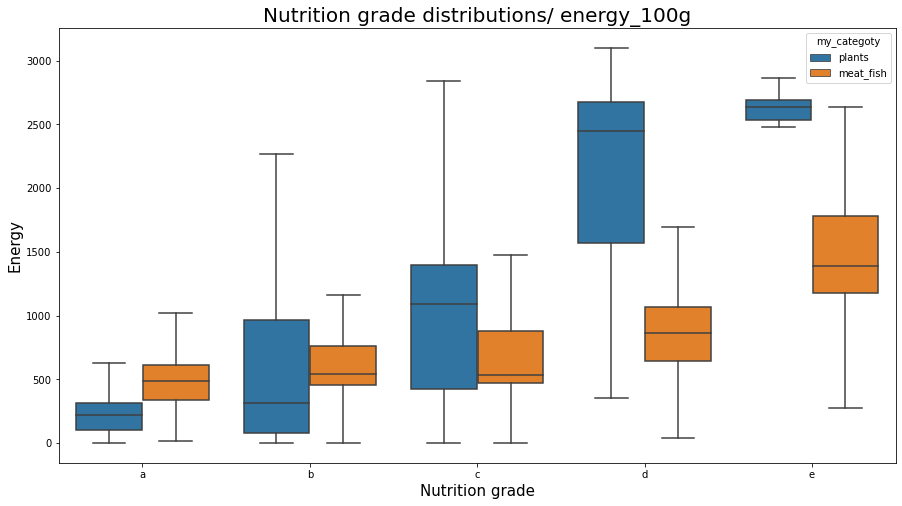

In [557]:
plt.figure(figsize=(15,8));
sns.boxplot(x="nutrition_grade_fr", y="energy_100g", data=df_selected[(df_selected.my_categoty == 'plants') | (df_selected.my_categoty == 'meat_fish')], showfliers = False, order = ['a', 'b', 'c', 'd', 'e'], hue =  'my_categoty')
plt.title('Nutrition grade distributions/ energy_100g', fontsize=20);
plt.xlabel('Nutrition grade', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

### Nutrition grade distributions over energy categorized by beverage and milk foods

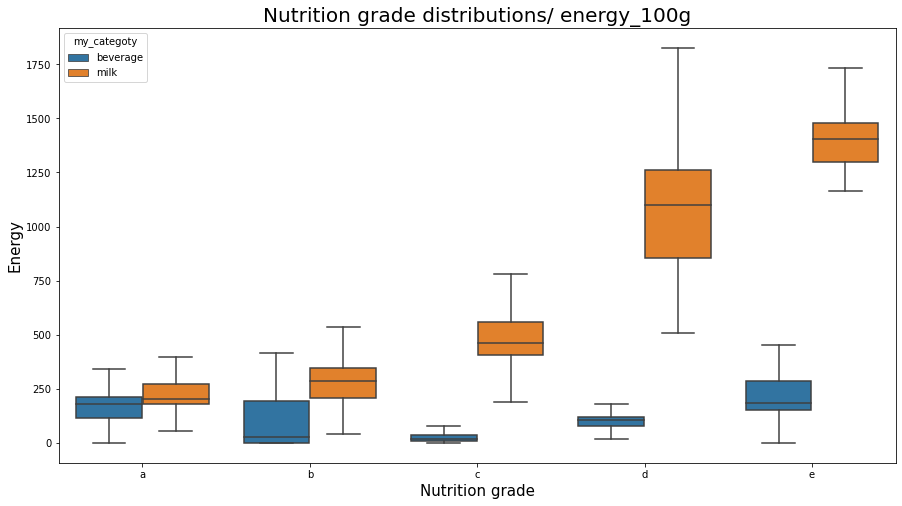

In [558]:
plt.figure(figsize=(15,8));
sns.boxplot(x="nutrition_grade_fr", y="energy_100g", data=df_selected[(df_selected.my_categoty == 'beverage') | (df_selected.my_categoty == 'milk')], showfliers = False, order = ['a', 'b', 'c', 'd', 'e'], hue =  'my_categoty')
plt.title('Nutrition grade distributions/ energy_100g', fontsize=20);
plt.xlabel('Nutrition grade', fontsize=15);
plt.ylabel('Energy', fontsize=15);
plt.show();

### Difference between `nutri-score-fr_100g` and `nutriscore-uk-100g`

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


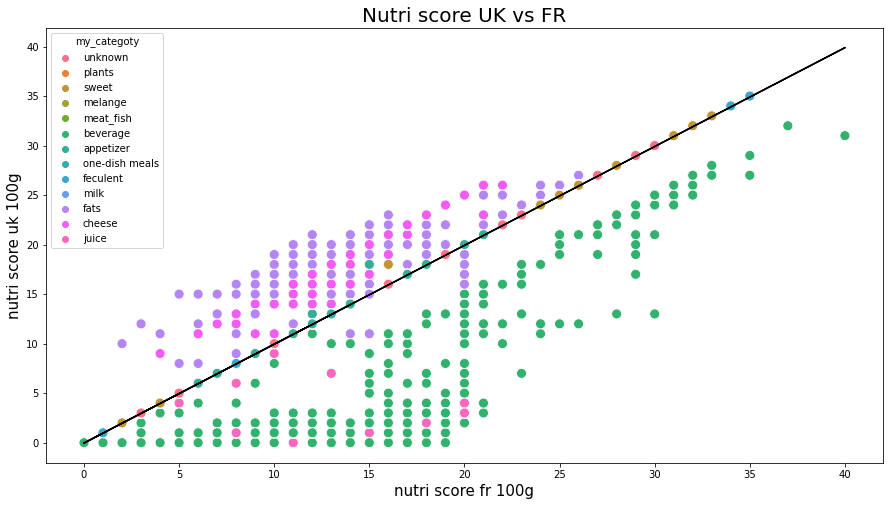

y=ax with a=[0.9978837]
 score : 0.9646914927984941


In [535]:
from sklearn.linear_model import LinearRegression
mask = (~df_selected['nutrition-score-fr_100g'].isna()) & (~df_selected['nutrition-score-uk_100g'].isna())
x=df_selected[mask]['nutrition-score-fr_100g']
y=df_selected[mask]['nutrition-score-uk_100g']

plt.figure(figsize=(15,8));
sns.scatterplot(x, 
                y, 
                hue = df_selected['my_categoty'],
                legend='full',
                s=100);

plt.title('Nutri score UK vs FR', fontsize=20);
plt.xlabel('nutri score fr 100g', fontsize=15);
plt.ylabel('nutri score uk 100g', fontsize=15);


#linear regression
x = np.array(x).reshape(-1, 1);
y = np.array(y).reshape(-1, 1);

reg = LinearRegression();
model = reg.fit(x, y);
plt.plot(x, droite.predict(x),color='k');
plt.show()

print('y=ax with a={}\n score : {}'.format(model.coef_[0], model.score(x, y)));

***Nutriscore for the two countries are rather similar, a linear model betweent them is easly modeled. However we see some difference in computation of nutriscore for some categories of ploducts:***
 - beverage are considered with a smaller nutrition score
 - fats are considered with a higher nutrition score
 - cheese are considered with a higher nutrition score

### How much energy for each category of foods?

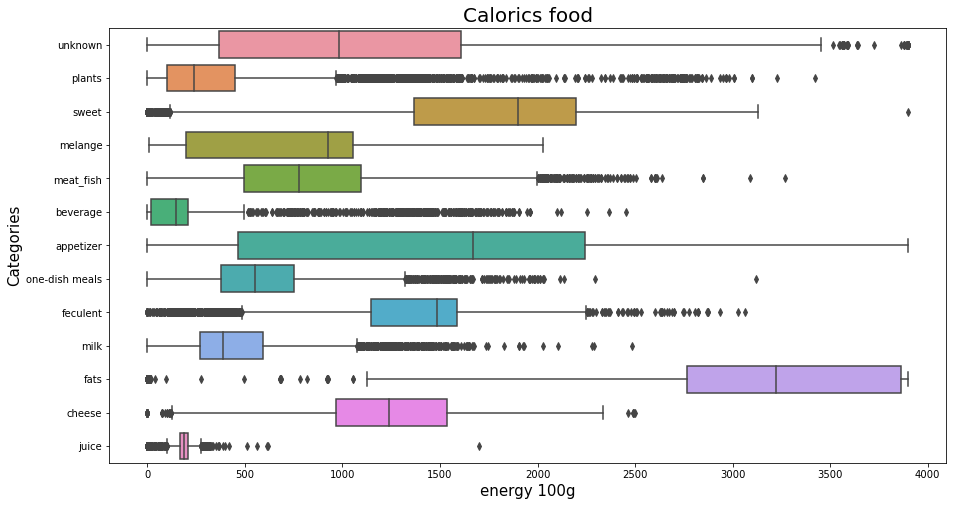

In [499]:
plt.figure(figsize=(15,8));
sns.boxplot(x="energy_100g", y="my_categoty", data=df_selected, orient = 'h');
plt.title('Calorics food', fontsize=20);
plt.xlabel('energy 100g', fontsize=15);
plt.ylabel('Categories', fontsize=15);
plt.show();

### How much fat for each category of foods?

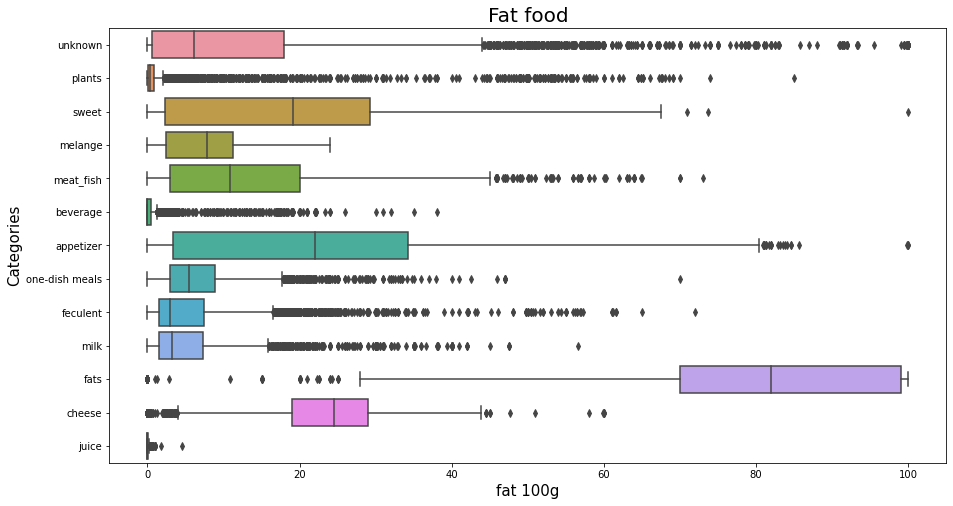

In [500]:
plt.figure(figsize=(15,8));
sns.boxplot(x="fat_100g", y="my_categoty", data=df_selected, orient = 'h');
plt.title('Fat food', fontsize=20);
plt.xlabel('fat 100g', fontsize=15);
plt.ylabel('Categories', fontsize=15);
plt.show();

## Faire une analyse exploratoire ACP (multivarié)

***ACP nous permet de:***
   - La variabilité entre les individus, c'est-à-dire quelles sont les différences et les ressemblances entre individus.
   - Les liaisons entre les variables : y a-t-il des groupes de variables très corrélées entre elles qui peuvent être regroupées en de nouvelles variables synthétiques ?

In [76]:
# selection des colonnes à prendre en compte dans l'ACP
columns_acp = []
for c in list(df_selected.columns):
    if c.endswith('_100g'):
        columns_acp.append(c)
df_pca = df_selected[columns_acp]

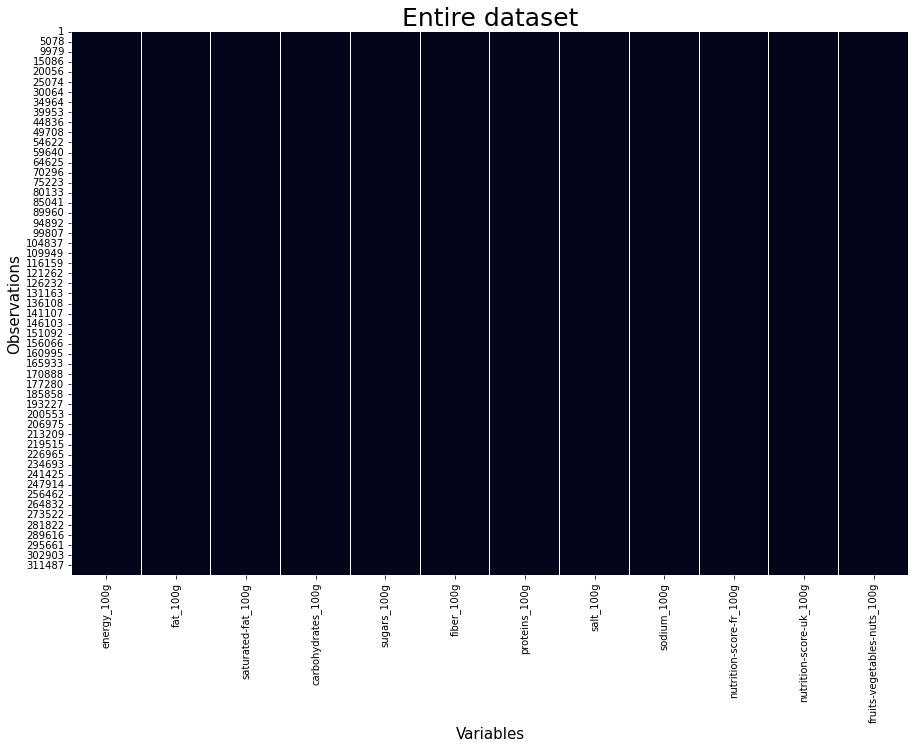

In [473]:
plot_data(df_pca)

In [80]:
# Preparation des données
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean');
X = np.array(df_pca['nutrition-score-fr_100g']).reshape(-1, 1);
imp.fit(X);
df_pca['nutrition-score-fr_100g'] = imp.transform(X);

X = np.array(df_pca['nutrition-score-uk_100g']).reshape(-1, 1);
imp.fit(X);
df_pca['nutrition-score-uk_100g'] = imp.transform(X);
#del X

/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/marius/opt/anaconda3/envs/oc3/lib/python3.6/site-packages/pandas/core/indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [82]:
X = df_pca.values
names = df_pca.index #["product_name"] # ou data.index pour avoir les intitulés
features = df_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

In [86]:
# choix du nombre de composantes à calculer
n_comp = 6

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

X_projected = pca.fit_transform(X_scaled)


X_projected = pd.DataFrame(X_projected, index = df_pca.index, columns = ['F{0}'.format(i) for i in range(n_comp)])

X_projected

PCA(n_components=6)

F0        F1        F2        F3        F4        F5
1       2.800735 -0.298114 -0.474938  0.110610  0.118867 -1.421463
2      -0.580925 -0.888546 -0.360955  2.978569  0.152684 -0.694340
3       2.152595  0.236326 -2.063974  1.848977  0.301407 -0.930790
4       0.099436 -0.697394  0.548852  1.419160 -0.048389  0.429295
5       0.978463 -0.639420 -0.043191  1.938429  0.087955  0.176426
...          ...       ...       ...       ...       ...       ...
320756  0.127126  0.042682 -0.484162 -0.261704 -0.008405 -0.964808
320757 -2.091499 -0.385563 -1.767761  2.531985  0.124616  0.980434
320763 -2.936513 -0.374991 -0.597558 -0.381112 -0.149653 -0.734596
320768 -3.120426 -0.407677 -0.618094 -0.362168 -0.149438 -0.864378
320771 -1.560371 -0.028785 -0.259742 -1.294376 -0.232629  0.337863

[260767 rows x 6 columns]

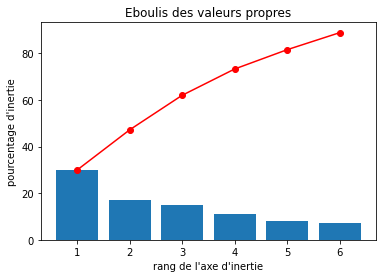

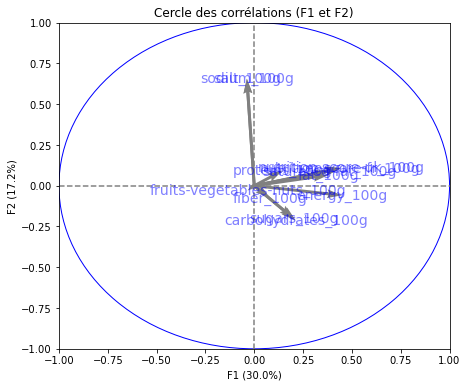

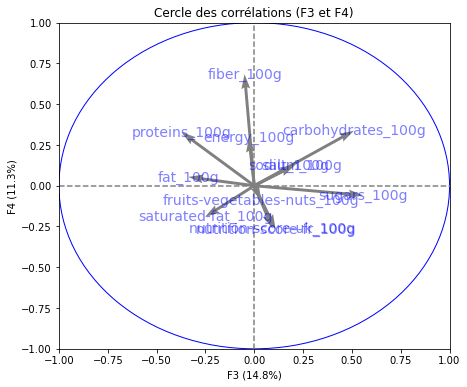

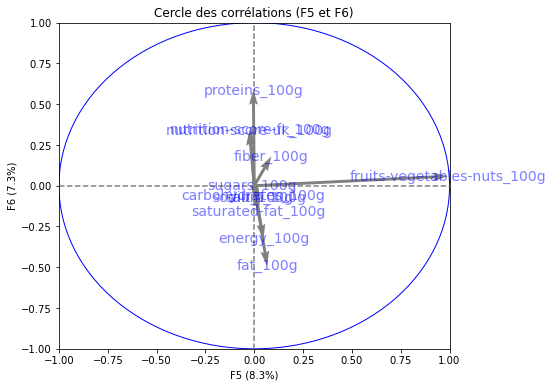

In [85]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1),(2,3),(4,5)], labels = np.array(features))

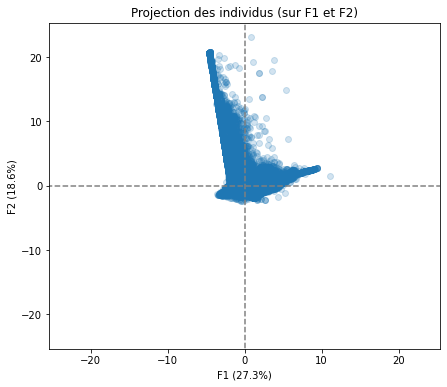

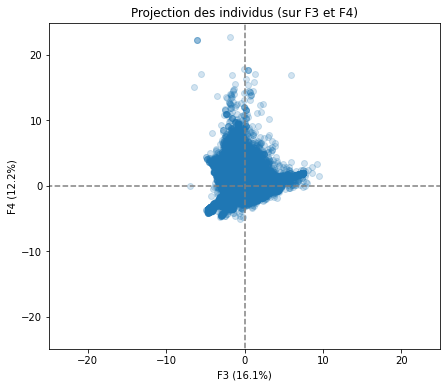

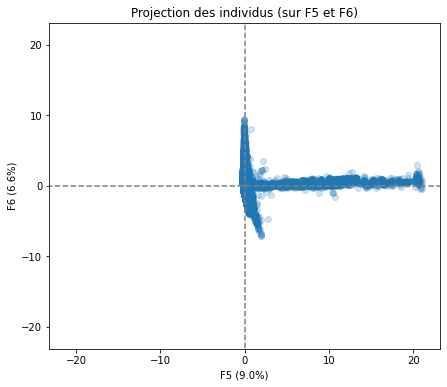

In [92]:
# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1),(2,3),(4,5)], alpha = 0.2)

# K-means algorithm avec ACP

In [211]:
cols = ['energy_100g', 'fat_100g', 'saturated-fat_100g',  'proteins_100g',  'nutrition_grade_fr', 
        'carbohydrates_100g']

df_selected_clustering = df_selected[cols]
df_selected_clustering = df_selected_clustering[~df_selected_clustering.nutrition_grade_fr.isna()]

clusters = df_selected_clustering['nutrition_grade_fr']
clusters = np.array(clusters.apply(lambda x: ord(x)-97)) # transformé en numeric
df_selected_clustering.drop('nutrition_grade_fr', inplace=True, axis=1)

features = df_selected_clustering.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(df_selected_clustering)
df_selected_clustering = std_scale.transform(df_selected_clustering)



In [212]:
n_comp = 2
# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(df_selected_clustering)
X_projected = pca.fit_transform(df_selected_clustering)

X_projected# = pd.DataFrame(X_projected, index = df_pca.index, columns = ['F{0}'.format(i) for i in range(n_comp)])

PCA(n_components=2)

array([[ 3.03514692, -0.50058059],
       [ 1.08440559, -0.77137787],
       [ 3.12397384,  0.78626913],
       ...,
       [-0.88462164,  1.63264941],
       [-1.96665734,  0.54173836],
       [-2.02328748,  0.52906735]])

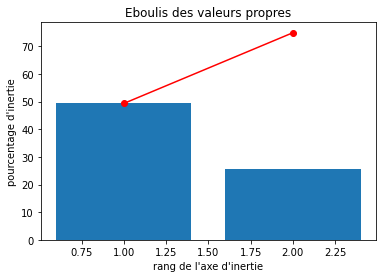

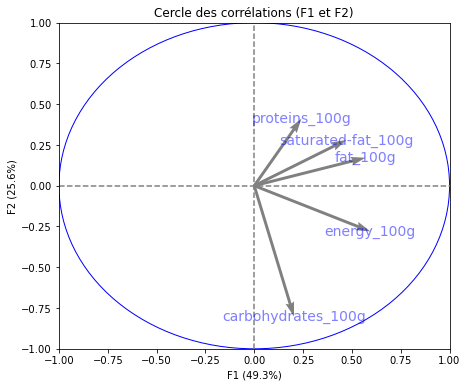

In [213]:
# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

In [559]:
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import metrics

K = len(np.unique(clusters))
kmeans = KMeans(n_clusters=K).fit(X_projected)

metrics.rand_score(clusters, kmeans.labels_)

0.6881286102756705